# 3D Rigid Body Motion

## Using Numpy/Scipy as a replacement for Eigen

In [1]:
import numpy as np

### Basic Matrix Ops

In [2]:
m = np.random.randn(3,3)
print(f"Transpose = {m.T}")
print(f"\nSum: {m.sum()}")
print(f"Trace: {m.trace()}")
print(f"\nScalar multiplication: {m * 10}")
print(f"\nInverse matrix: {np.linalg.inv(m)}") # <- Computed inverse using LU factorisation
print(f"\nDeterminant: {np.linalg.det(m)}")

Transpose = [[ 0.80910634  0.68541877  1.0966223 ]
 [ 0.07921505  0.14575503 -0.8636759 ]
 [-1.27007197  1.29181071  0.25660854]]

Sum: 2.230788860144554
Trace: 1.2114699090505572

Scalar multiplication: [[  8.09106337   0.79215047 -12.70071971]
 [  6.85418765   1.45755028  12.91810712]
 [ 10.96622299  -8.63675901   2.56608545]]

Inverse matrix: [[ 0.58057868  0.54205941  0.14472842]
 [ 0.62470274  0.80579249 -0.96455839]
 [-0.37853308  0.39557963  0.03204003]]

Determinant: 1.986135223846424


In [3]:
# Eigen values
s = m.T @ m # construct a real symmetric matrix: A^T A
eigVals, eigVecs = np.linalg.eigh(s) # `eigh` is optimised for symmetric matrices, compared to the generalist `eig`
print(f"Eigen Values: {eigVals}")
print(f"Eigen Vectors: {eigVecs}")

Eigen Values: [0.4455039  2.60951735 3.39317246]
Eigen Vectors: [[ 0.38261938  0.89989212  0.20927634]
 [ 0.92358713 -0.36659461 -0.11222833]
 [ 0.02427381 -0.23622567  0.97139498]]


In [4]:
# Solving Equations
sz = 100
A = np.random.randn(sz, sz)
A = A @ A.T # Make `A` into a positive semi-definite matrix (x^T.M.x >= 0) by representing it as a symmetric matrix
b = np.random.randn(sz)
# By positive semi-definiteness, `b.T @ A @ b` >= 0

In [5]:
# by direct inversion using LU factorisation
x = np.linalg.inv(A) * b
print(f"Condition number for A: {np.linalg.cond(A)}, (could be worse)")
print(np.linalg.norm(x))

Condition number for A: 14951.079015425856, (could be worse)
39.4594838725648


In [6]:
# QR decomposition
import scipy
def qr_solve(A, b):
    Q, R = np.linalg.qr(A)
    # Q is orthonormal, therefore, its transpose is also its inverse
    p = Q.T @ b
    Rinv = np.linalg.inv(R) # can't be bothered to solve directly using upper triangular R structure
    return Rinv @ p
    # return scipy.linalg.solve_triangular(R, p)

x = qr_solve(A, b)
print(np.linalg.norm(x)) # <- norm is much lower here, QR decomp is much more stable and accurate

15.872796947100692


In [7]:
# Cholesky decomp
L = np.linalg.cholesky(A)
y = np.linalg.solve(L, b)
x = np.linalg.solve(L.T, y)
print(np.linalg.norm(x))

15.872796947099008


## Replicating Eigen Geometry with Numpy/Scipy

In [8]:
from scipy.spatial.transform import Rotation as R

In [9]:
id_rot = R.identity()
print(id_rot.as_matrix())
print(id_rot.as_quat()) # scalar last format
print(id_rot.as_rotvec())

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0. 1.]
[0. 0. 0.]


In [10]:
# Axis Angle Representation
rotvec = R.from_euler('z', np.pi/4) # 45 degree rotation along the z-axis
print(rotvec.as_matrix)

v = np.array([1, 0, 0])
v_rotated = rotvec.apply(v)
print(v_rotated)

<bound method Rotation.as_matrix of <scipy.spatial.transform._rotation.Rotation object at 0x107c39020>>
[0.70710678 0.70710678 0.        ]


In [11]:
from Transforms import Transform

T = Transform.identity()

T.rotate(rotvec)
# T.pretranslate(np.array([1, 3, 4]))

v = np.array([1, 0, 0])
v_rot = T * v
print(v_rot)

[0.70710678 0.70710678 0.        ]


In [12]:
q = rotvec
v_rot = q.apply(v)
print(v_rot)

[0.70710678 0.70710678 0.        ]


In [13]:
# Coordinate transformation example
# No need to normalise raw initial values as scipy would perform the normalisation
P1 = Transform(R.from_quat([0.2, 0.3, 0.1, 0.35]), np.array([0.3, 0.1, 0.1]))
P2 = Transform(R.from_quat([0.4, -0.1, 0.2, -0.5]), np.array([-0.1, 0.5, 0.3]))

ptP1 = np.array([0.5, 0, 0.2, 1]) # Added trailing `1` to make it homogeneous

ptWorldOrigin = P1.inv() @ ptP1 # `P1.inv()` is the transform from robot 1 to the world coordinates
ptP2 = P2 * ptWorldOrigin
print(f"Point in robot 2's coordinate:\n{ptP2}")


Point in robot 2's coordinate:
[-0.03097308  0.73498965  0.29610766  1.        ]


## Trajectory Plotting

Download txt file from `https://github.com/gaoxiang12/slambook2/blob/master/ch3/examples/trajectory.txt`

In [14]:
lines = np.loadtxt("./resources/trajectory.txt")

# The trajectories are in the world to robot format (i think)
numPoints = lines.shape[0]
data = []
for i in range(numPoints):
    time = lines[i, 0]
    t = lines[i,1:4]
    q = lines[i, 4:] # quaternions are already in the scalar last format
    T = Transform(R.from_quat(q), t)
    data.append((time, T))

# data is a list of tuples of (time, transform)

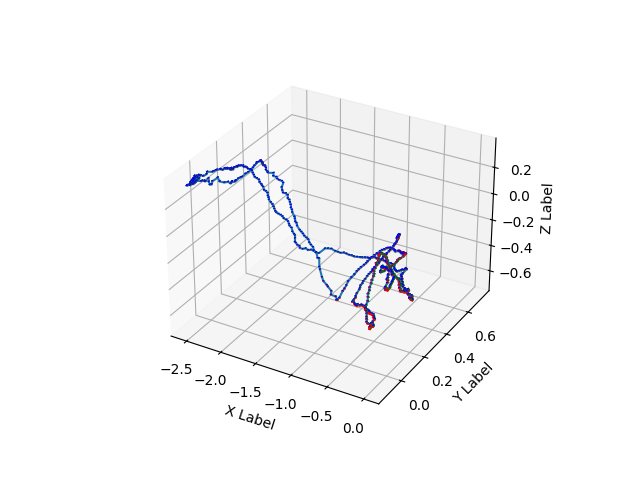

In [15]:
import matplotlib.pyplot as plt

# Ensure the required backend is installed using `pip install ipympl`
%matplotlib widget 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(lines[:,1], lines[:,2], lines[:,3])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')


for i in range(lines.shape[0]):
    _, T = data[i]

    xAxis = np.array([1, 0, 0, 1])
    rotatedAxis = T * xAxis
    rotatedAxis = rotatedAxis[:-1]
    ax.quiver(
        *T.t,
        *rotatedAxis,
        color='red', length=0.01, normalize=True
    )

    yAxis = np.array([0, 1, 0, 1])
    rotatedAxis = T * yAxis
    rotatedAxis = rotatedAxis[:-1]
    ax.quiver(
        *T.t,
        *rotatedAxis,
        color='green', length=0.01, normalize=True
    )

    zAxis = np.array([0, 0, 1, 1])
    rotatedAxis = T * zAxis
    rotatedAxis = rotatedAxis[:-1]
    ax.quiver(
        *T.t,
        *rotatedAxis,
        color='blue', length=0.01, normalize=True
    )

plt.show()

%matplotlib inline